<H1>Multivariate prediction of difference in flows</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
import os
from plotly.subplots import make_subplots

In [63]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]
df = pd.read_excel(directory_list[2])     #This contains the flow.bc (Mass Balance Correction) values
df_input_roc= pd.read_excel(directory_list[3])
df = df[1:]
df_input_roc= df_input_roc[1:-1]
df_input = df

df.index = pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')

<h2>Preprocessing data </h2>

<h3>Input data</h3>

In [64]:
features_for_input=['ANDER/flow.bc',
                 #'MENDE/flow.bc',
                 #'OPLAD/flow.bc',
                 #'NEUBR/flow.bc',
                 #'RUHRW/flow.bc',
                 #'SCHER/flow.bc',
                 ]
features_for_input_roc= ['Rate of change ANDER/flow.bc']
df_input=df_input[features_for_input].reset_index(drop=True)
df_input_roc=df_input_roc[features_for_input_roc].reset_index(drop=True)
df_input, df_input_roc

(      ANDER/flow.bc
 0              2120
 1              2020
 2              2000
 3              2090
 4              2020
 ...             ...
 3647           1160
 3648           1110
 3649           1110
 3650           1080
 3651           1070
 
 [3652 rows x 1 columns],
       Rate of change ANDER/flow.bc
 0                           -120.0
 1                           -100.0
 2                            -20.0
 3                             90.0
 4                            -70.0
 ...                            ...
 3646                         -50.0
 3647                         -20.0
 3648                         -50.0
 3649                           0.0
 3650                         -30.0
 
 [3651 rows x 1 columns])

<h3>Adding periodicity for date</h3>

In [65]:
time=df['Date']
df_time=pd.DataFrame({'Date': time})
df_time['Seconds']=df_time.index.map(pd.Timestamp.timestamp)

#df_time['Day sin']= np.sin(df_time['Seconds']*(2*np.pi/86400))
#df_time['Day cos']= np.cos(df_time['Seconds']*(2*np.pi/86400))
df_time['Year sin']= np.sin(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time['Year cos']= np.cos(df_time['Seconds']*(2*np.pi/86400/365.2425))
df_time=df_time.drop('Date',axis=1)
df_time=df_time.drop('Seconds',axis=1)
df_time=df_time.reset_index(drop=True)

In [66]:
df_input_concatenated=pd.concat([df_time,df_input_roc,df_input],axis=1,ignore_index=True)
df_input_concatenated=df_input_concatenated[0:-1]
X_val = df_input_concatenated   #validation dataset

df_input_concatenated, X_val,df_input

(             0         1      2     3
 0    -1.000000  0.000097 -120.0  2120
 1    -0.999850  0.017299 -100.0  2020
 2    -0.999405  0.034495  -20.0  2000
 3    -0.998664  0.051682   90.0  2090
 4    -0.997627  0.068853  -70.0  2020
 ...        ...       ...    ...   ...
 3646 -0.993909 -0.110207  -50.0  1180
 3647 -0.995657 -0.093093  -20.0  1160
 3648 -0.997111 -0.075952  -50.0  1110
 3649 -0.998270 -0.058789    0.0  1110
 3650 -0.999134 -0.041608  -30.0  1080
 
 [3651 rows x 4 columns],
              0         1      2     3
 0    -1.000000  0.000097 -120.0  2120
 1    -0.999850  0.017299 -100.0  2020
 2    -0.999405  0.034495  -20.0  2000
 3    -0.998664  0.051682   90.0  2090
 4    -0.997627  0.068853  -70.0  2020
 ...        ...       ...    ...   ...
 3646 -0.993909 -0.110207  -50.0  1180
 3647 -0.995657 -0.093093  -20.0  1160
 3648 -0.997111 -0.075952  -50.0  1110
 3649 -0.998270 -0.058789    0.0  1110
 3650 -0.999134 -0.041608  -30.0  1080
 
 [3651 rows x 4 columns],
       A

<h3>Creating the label dataframe</h3>

In [67]:
output_attributes=['BONN/flow.obs',
                   'BONN/flow.bc'
                    #'KOELN/flow.obs',
                    #'DUESS/flow.obs',
                    #'DUISB/flow.obs',
                    #'WESEL/flow.obs',
                    #'REES/flow.obs',
                    #'EMMER/flow.obs'
                    ]
df_output=df[output_attributes]
df_output=df_output[0:-1]
y_val=df_output
y_val


,BONN/flow.obs,BONN/flow.bc
Date,,
1995-10-02,2100,7.900924
1995-10-03,2010,12.672501
1995-10-04,1950,-17.016998
1995-10-05,2050,-21.090261
1995-10-06,1990,-0.186959
...,...,...
2005-09-25,1170,9.637902
2005-09-26,1140,-1.726941
2005-09-27,1100,6.507338


<h2>Splitting data into test, validation and train with window size</h2>

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_input_concatenated, df_output, test_size=0.33, random_state=42)


In [69]:
scaler_x=StandardScaler()
scaler_y=StandardScaler()

X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test))
X_val_scaled = pd.DataFrame(scaler_x.transform(X_val))

y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train))
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test))
y_val_scaled= pd.DataFrame(scaler_y.transform(y_val))

<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [70]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(100, activation='relu'),
    Dense(y_train_scaled.shape[1])  # Output layer
])

c:\Projects\venv0.7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h2> Compile the model </h2>

In [71]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, validation_split=0.3)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0572 - mean_absolute_error: 0.6566 - val_loss: 0.7327 - val_mean_absolute_error: 0.5460
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9173 - mean_absolute_error: 0.5994 - val_loss: 0.5552 - val_mean_absolute_error: 0.4755
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6233 - mean_absolute_error: 0.4947 - val_loss: 0.4161 - val_mean_absolute_error: 0.4086
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4052 - mean_absolute_error: 0.4064 - val_loss: 0.2964 - val_mean_absolute_error: 0.3463
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3333 - mean_absolute_error: 0.3629 - val_loss: 0.2072 - val_mean_absolute_error: 0.2898
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2070 - mean_absolute_error: 0.2878 - val_loss: 0.1481 - val_mean_absolute_error: 0.2438
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1608 - mean_absolute_error: 0.2524 - val_los

<h2>Model evaluation </h2>

In [73]:
predictions = model.predict(X_test_scaled)
predictions_rescaled = scaler_y.inverse_transform(predictions)

mae_FFNN=mean_absolute_error(y_test, predictions_rescaled)
mse_FFNN=mean_squared_error(y_test, predictions_rescaled)

predictions_FFNN_df=pd.DataFrame(predictions_rescaled)
predictions_FFNN_df.columns=y_test.columns

op=pd.DataFrame(predictions_rescaled)
mae_FFNN, mse_FFNN

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(20.93236880586927, 1093.7774355387542)

<h2>Plotting the validation loss and training loss</h2>

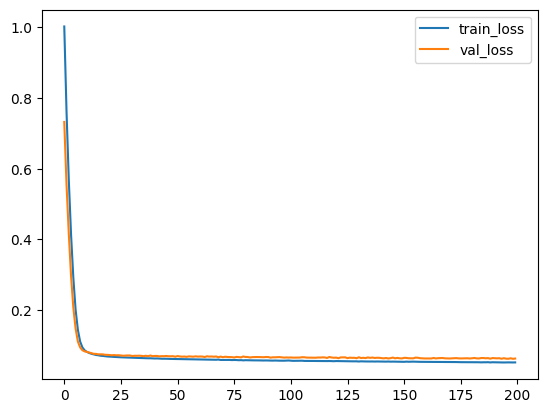

In [74]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

<h2>Validation </h2>

In [75]:
predictions_val = model.predict(X_val_scaled)
predictions_rescaled_val = scaler_y.inverse_transform(predictions_val)

mae_FFNN_val=mean_absolute_error(y_val, predictions_rescaled_val)
mse_FFNN_val=mean_squared_error(y_val, predictions_rescaled_val)

predictions_FFNN_df_val=pd.DataFrame(predictions_rescaled_val)
predictions_FFNN_df_val.columns=y_val.columns

op=pd.DataFrame(predictions_rescaled_val)

mae_FFNN_val, mse_FFNN_val

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(20.245982972552, 946.3832428010945)

<h2>Evaluation metrics for each and every label</h2>

In [48]:
mae_dict_FFNN_val = {}
mse_dict_FFNN_val = {}
for column in predictions_FFNN_df_val.columns:
    mae_val = mean_absolute_error(y_val[column], predictions_FFNN_df_val[column])
    mse_val = mean_squared_error(y_val[column], predictions_FFNN_df_val[column])
    mae_dict_FFNN_val[column] = mae_val
    mse_dict_FFNN_val[column] = mse_val

print("MAE for each column:")
for column, mae_val in mae_dict_FFNN_val.items():
    print(f"{column}: {mae_val}")

print("\nMSE for each column:")
for column, mse_val in mse_dict_FFNN_val.items():
    print(f"{column}: {mse_val}")


MAE for each column:
BONN/flow.obs: 27.29367734960777
BONN/flow.bc: 12.804911918969886

MSE for each column:
BONN/flow.obs: 1486.4656812794694
BONN/flow.bc: 302.9976820721291


<h1>Linear Regression</h1>

In [49]:
regressor= LinearRegression()

model_linear_disch= regressor.fit(X_val,y_val.iloc[:,0])
prediction_linear_disch= regressor.predict(X_val)

mae_val_lin_disch = mean_absolute_error(y_val.iloc[:,0], prediction_linear_disch)
mse_val_lin_disch = mean_squared_error(y_val.iloc[:,0], prediction_linear_disch)

model_linear= regressor.fit(df_input_roc,y_val.iloc[:,1])
prediction_linear= regressor.predict(df_input_roc)

mae_val_lin = mean_absolute_error(y_val.iloc[:,1], prediction_linear)
mse_val_lin = mean_squared_error(y_val.iloc[:,1], prediction_linear)
mae_val_lin_disch, mae_val_lin

(27.347994992331067, 16.190407605236064)

<h2>Output visualization</h2>

In [104]:
i = 0
data = {
    'Date': y_val.index,
    'Discharge MIMO FFNN': predictions_rescaled_val[:, i],
    'Flow observed': np.array(y_val)[:, i],
    'MBC MIMO FFNN': predictions_rescaled_val[:, i+1],
    'MBC Lin Reg': prediction_linear,
    'MBC DA': np.array(y_val)[:, i+1],
}

df_plot_val = pd.DataFrame(data)
df_plot_val['Random error FFNN'] = df_plot_val['MBC DA'] - df_plot_val['MBC MIMO FFNN']
df_plot_val['Random error LR'] = df_plot_val['MBC DA'] - df_plot_val['MBC Lin Reg']

# Create subplots
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'Discharge prediction using FFNN ' + df_output.columns[i],
        'MBC prediction ' + df_output.columns[i],
        'Random error ' + df_output.columns[i]
    ),
    vertical_spacing=0.05
)

# Add traces for the first subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'], 
               y=df_plot_val['Discharge MIMO FFNN'],
               mode='lines',
               name='Discharge MIMO FFNN',
               legendgroup='1',
               marker={'color': 'red'}),
    row=1, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Flow observed'],
               mode='lines',
               name='Flow observed',
               legendgroup='1',
               marker={'color': 'green'}),
    row=1, col=1
)

# Add traces for the second subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC MIMO FFNN'],
               mode='lines',
               name='MBC MIMO FFNN',
               legendgroup='2',
               marker={'color': 'red'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='2',
               marker={'color': 'blue'}),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC Lin Reg'],
               mode='lines',
               name='MBC Lin Reg',
               legendgroup='2',
               marker={'color': 'goldenrod'}),
    row=2, col=1
)

# Add traces for the third subplot
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error FFNN'],
               mode='lines',
               name='Random error FFNN',
               legendgroup='3',
               marker={'color': 'red'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['MBC DA'],
               mode='lines',
               name='MBC DA',
               legendgroup='3',
               marker={'color': 'blue'}),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=df_plot_val['Date'],
               y=df_plot_val['Random error LR'],
               mode='lines',
               name='Random error LR',
               legendgroup='3',
               marker={'color': 'goldenrod'}),
    row=3, col=1
)

# Update layout
fig.update_layout(
    height=1100, width=900,
    template='simple_white',
    xaxis={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    yaxis={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    xaxis2={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    yaxis2={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    xaxis3={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    yaxis3={'showline': True, 'linewidth': 1, 'linecolor': 'black', 'mirror': True},
    legend_tracegroupgap = 270,
    legend={
        'x': 0.75, # x position
        'y': 0.99, # y position
        'bgcolor': 'rgba(0, 0, 0, 0)'
    }
)

fig.update_xaxes(title_text="Date", row=3, col=1)  # Example for updating x-axis label of the third subplot
fig.update_yaxes(title_text="Discharge (m³/s)", row=1, col=1)
fig.update_yaxes(title_text="MBC (m³/s)", row=2, col=1)
fig.update_yaxes(title_text="Discharge (m³/s)", row=3, col=1)

fig.show()